# Trabalho IAA011 - Visão Computacional

## Equipe 03
* Gustavo Costa de Souza
* Marcos Vinicius de Melo
* Marcus Eneas Silveira Galvao do Rio Apa II
* Patrícia Verdugo Pascoal
* Rodrigo de Araujo
* William de Souza Alencar

# 1. Extração de Características

Os bancos de imagens fornecidos são conjuntos de imagens de 250x250 pixels de imuno-histoquímica (biópsia) de câncer de mama. No total são 4 classes (0, 1+, 2+ e 3+) que estão divididas em diretórios. O objetivo é classificar as imagens nas categorias correspondentes. Uma base de imagens será utilizada para o treinamento e outra para o teste do treino.
As imagens fornecidas são recortes de uma imagem maior do tipo WSI (Whole Slide Imaging) disponibilizada pela Universidade de Warwick (link). A nomenclatura das imagens segue o padrão XX_HER_YYYY.png, onde XX é o número do paciente e YYYY é o número da imagem recortada. Separe a base de treino em 80% para treino e 20% para validação. Separe por pacientes (XX), não utilize a separação randômica! Pois, imagens do mesmo paciente não podem estar na base de treino e de validação, pois isso pode gerar um viés. No caso da CNN VGG16 remova a última camada de classificação e armazene os valores da penúltima camada como um vetor de características. Após o treinamento, os modelos treinados devem ser validados na base de teste.

Tarefas:
1. Carregue a base de dados de Treino.
2. Crie partições contendo 80% para treino e 20% para validação (atenção aos pacientes).
3. Extraia características utilizando LBP e a CNN VGG16 (gerando um csv para cada extrator).
4. Treine modelos Random Forest, SVM e RNA para predição dos dados extraídos (nessa tarefa utilize todas as imagens para o treinamento).
5. Carregue a base de Teste e execute a tarefa 3 nesta base.
6. Aplique os modelos treinados nos dados de teste.
7. Calcule as métricas de Sensibilidade, Especificidade e F1-Score com base em suas matrizes de confusão.
8. Indique qual modelo dá o melhor o resultado e a métrica utilizada

In [153]:
import os
import shutil
from collections import defaultdict
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

### 1. Carregue a base de dados de Treino.

In [239]:
!tar -xf Train_Warwick.zip -C train

### 2. Crie partições contendo 80% para treino e 20% para validação (atenção aos pacientes).

In [180]:
BASE_DIR_TRAIN = 'train/Train_4cls_amostra'
OUTPUT_DIR_TRAIN = 'train_split' 

classes = ['0', '1', '2', '3']

for tp in ['train', 'val']:
    for cls in classes:
        os.makedirs(os.path.join(OUTPUT_DIR, tp, cls), exist_ok=True)

patient_images = defaultdict(list)

for cls in classes:
    class_dir = os.path.join(BASE_DIR_TRAIN, cls)
    for filename in os.listdir(class_dir):
        if filename.endswith('.png'):            
            patient_id = filename.split('_')[0]
            img_path = os.path.join(class_dir, filename)
            patient_images[patient_id].append((cls, img_path))

patients = list(patient_images.keys())

# Divide os pacientes (80% treino, 20% validação)
train_patients, val_patients = train_test_split(
    patients, test_size=0.2, random_state=42
)

def copy_images(patients, split_name):
    for patient in patients:
        for cls, img_path in patient_images[patient]:
            dest_dir = os.path.join(OUTPUT_DIR_TRAIN, split_name, cls)
            shutil.copy(img_path, dest_dir)

print("Copiando imagens de treino...")
copy_images(train_patients, 'train')

print("Copiando imagens de validação...")
copy_images(val_patients, 'val')

print("Separação concluída com sucesso!")
print(f"Total de pacientes de treino: {len(train_patients)}")
print(f"Total de pacientes de validação: {len(val_patients)}")

Copiando imagens de treino...
Copiando imagens de validação...
Separação concluída com sucesso!
Total de pacientes de treino: 16
Total de pacientes de validação: 4


### 3. Extraia características utilizando LBP e a CNN VGG16 (gerando um csv para cada extrator).

#### Extrator LBP

In [185]:
%%time
RADIUS = 1
N_POINTS = 8 * RADIUS
METHOD = 'uniform'

def extract_lbp_hist_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)    
    
    lbp = local_binary_pattern(image, N_POINTS, RADIUS, METHOD)

    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist


def extract_lbp(dir_path):
    features = []
    labels = []    
    for cls in classes:
        class_dir = os.path.join(dir_path, cls)
        for filename in tqdm(os.listdir(class_dir), desc=f"Extraindo LBP da classe ({cls})"):            
            img_path = os.path.join(class_dir, filename)
            hist = extract_lbp_hist_features(img_path)
            features.append(hist)
            labels.append(cls)                    
    return features, labels

features, labels = extract_lbp(BASE_DIR_TRAIN)

features = np.array(features)
labels = np.array(labels)

print("Formato do vetor de características LBP:", features.shape)
print("Exemplo de histograma LBP:", features[0])

# Exporta os histogramas LBP para o CSV
df_lbp = pd.DataFrame(features)
df_lbp['label'] = labels

output_csv_lbp_train = 'lbp_features_train.csv'
df_lbp.to_csv(output_csv_lbp_train, index=False)

print(f"Arquivo CSV gerado com sucesso: {output_csv_lbp_train}")
print(f"Dimensões: {df_lbp.shape[0]} amostras x {df_lbp.shape[1]} colunas")

Extraindo LBP da classe (3): 100%|███████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 49.92it/s]

Formato do vetor de características LBP: (593, 10)
Exemplo de histograma LBP: [0.013488 0.033344 0.04144  0.159392 0.356192 0.212496 0.071904 0.0356
 0.03176  0.044384]
Arquivo CSV gerado com sucesso: lbp_features_train.csv
Dimensões: 593 amostras x 11 colunas
CPU times: total: 10.7 s
Wall time: 11.6 s


#### Extrator CNN VGG16

In [186]:
%%time
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Carrega o modelo VGG16 pré-treinado no ImageNet, sem a camada de classificação
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model_vgg16 = Model(inputs=vgg16.input, outputs=vgg16.output)

print("Modelo VGG16 carregado. Dimensões da última camada: ", model_vgg16.output_shape)

def extract_vgg16_features(img_path):
    # Carrega imagem e redimensiona para 224x224 (padrão VGG16)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Extrai características
    features = model_vgg16.predict(img_array, verbose=0)
    return features.flatten()

def extract_vgg(dir_path):
    features_vgg = []
    labels_vgg = []
    
    for cls in classes:
        class_dir = os.path.join(dir_path, cls)
        for filename in tqdm(os.listdir(class_dir), desc=f"Extraindo VGG16 da classe ({cls})"):
            img_path = os.path.join(class_dir, filename)
            vec = extract_vgg16_features(img_path)
            features_vgg.append(vec)
            labels_vgg.append(cls)
    return features_vgg, labels_vgg

features_vgg, labels_vgg = extract_vgg(BASE_DIR_TRAIN)
print("Número de imagens:", len(features_vgg))

# salva no CSV
features_vgg = np.array(features_vgg)
labels_vgg = np.array(labels_vgg)
df_vgg = pd.DataFrame(features_vgg)
df_vgg['label'] = labels_vgg

output_csv = 'vgg16_features_train.csv'
df_vgg.to_csv(output_csv, index=False)

print(f"\nExtração concluída. Arquivo salvo em: {output_csv}")
print(f"Dimensões: {df_vgg.shape[0]} amostras x {df_vgg.shape[1]} colunas")

Modelo VGG16 carregado. Dimensões da última camada:  (None, 7, 7, 512)


Extraindo VGG16 da classe (3): 100%|█████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Número de imagens: 593

Extração concluída. Arquivo salvo em: vgg16_features_train.csv
Dimensões: 593 amostras x 25089 colunas
CPU times: total: 13min 41s
Wall time: 3min 7s


### 4. Treine modelos Random Forest, SVM e RNA para predição dos dados extraídos (nessa tarefa utilize todas as imagens para o treinamento).

#### Treinando os modelos utilizando as características LBP

In [214]:
%%time
df_lbp = pd.read_csv('lbp_features_train.csv')

print("Formato do DataFrame LBP:", df_lbp.shape)
#print(df_lbp.head(2))

X = df_lbp.drop(columns=['label']).to_numpy(dtype=np.float32)
y = df_lbp['label'].to_numpy(dtype=np.int32)

print("X shape:", X.shape)
print("y shape:", y.shape)

Formato do DataFrame LBP: (593, 11)
X shape: (593, 10)
y shape: (593,)
CPU times: total: 0 ns
Wall time: 33.5 ms


##### SVM

In [238]:
%%time

from sklearn.svm import SVC

# Cria e treina o classificador SVM
def svm(X, y):    
    svm = SVC(kernel='rbf', gamma='scale', C=1, verbose=True, random_state=42, class_weight='balanced')
    svm.fit(X, y)    
    print("Modelo SVM treinado")
    return svm

svm_lbp = svm(X, y)

print("Número de vetores de suporte por classe:", svm_lbp.n_support_)

[LibSVM]Modelo SVM treinado
Número de vetores de suporte por classe: [139 145 143 136]
CPU times: total: 6min 1s
Wall time: 24.3 s


##### Random Forest

In [215]:
%%time
from sklearn.ensemble import RandomForestClassifier

def rf(X, y):
    rf = RandomForestClassifier(n_estimators=100, random_state=42, verbose=True )
    rf.fit(X, y)
    print("Modelo RF treinado")
    return rf
    
rf_clf_lbp = rf(X, y)

Modelo RF treinado
CPU times: total: 172 ms
Wall time: 186 ms


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


##### RNA

In [195]:
%%time
from sklearn.neural_network import MLPClassifier

def rna(X, y):
    rna = MLPClassifier(hidden_layer_sizes=(15,), activation='relu', alpha=0.1, solver='adam',
                        max_iter=3000, random_state=42, verbose=False)
    rna.fit(X, y)    
    print("Modelo RNA treinado")
    return rna

rna_lbp = rna(X, y)

Modelo RNA treinado
CPU times: total: 14.7 s
Wall time: 16.3 s


#### Treinando os modelos utilizando as características VGG16

In [218]:
%%time
df_vgg = pd.read_csv('vgg16_features_train.csv')

print("Formato do DataFrame VGG:", df_vgg.shape)

X = df_vgg.drop(columns=['label']).to_numpy(dtype=np.float32)
y = df_vgg['label'].to_numpy(dtype=np.int32)

print("X shape:", X.shape)
print("y shape:", y.shape)

Formato do DataFrame VGG: (593, 25089)
X shape: (593, 25088)
y shape: (593,)
CPU times: total: 2.56 s
Wall time: 2.61 s


In [197]:
%%time
svm_vgg = svm(X, y)

print("Número de vetores de suporte por classe:", svm_vgg.n_support_)

[LibSVM]Modelo SVM LBP treinado
Número de vetores de suporte por classe: [139 145 143 136]
CPU times: total: 48min 32s
Wall time: 6min 19s


In [219]:
%%time
rf_clf_vgg = rf(X, y)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


Modelo RF treinado
CPU times: total: 859 ms
Wall time: 870 ms


In [199]:
%%time
rna_vgg = rna(X, y)

Modelo RNA treinado


### 5. Carregue a base de Teste e execute a tarefa 3 nesta base.

In [201]:
!tar -xf Test_Warwick.zip -C test

In [202]:
%%time
BASE_DIR_TEST = 'test/Test_4cl_amostra'

features = []
labels = []
features, labels = extract_lbp(BASE_DIR_TEST)

features = np.array(features, dtype=np.float32)  # vetor 1D por imagem
labels = np.array(labels)
imgs_original = np.array(imgs_original)

print("Número de imagens:", len(features))

## exporta para csv
df_lbp = pd.DataFrame(features)
df_lbp['label'] = labels

#print(df_lbp.head(2))

output_csv = 'lbp_features_test.csv'
df_lbp.to_csv(output_csv, index=False)

print(f"Arquivo CSV gerado com sucesso: {output_csv}")
print(f"Dimensões: {df_lbp.shape[0]} amostras x {df_lbp.shape[1]} colunas")

Extraindo LBP da classe (3): 100%|████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 125.99it/s]

Número de imagens: 371
Arquivo CSV gerado com sucesso: lbp_features_test.csv
Dimensões: 371 amostras x 11 colunas
CPU times: total: 2.75 s
Wall time: 2.84 s


In [203]:
%%time
df_lbp_test = pd.read_csv('lbp_features_test.csv')

print("Formato do DataFrame de teste:", df_lbp_test.shape)
#print(df_lbp_test.head(2))

X_test = df_lbp.drop(columns=['label']).to_numpy(dtype=np.float64)
y_test = df_lbp['label'].to_numpy(dtype=np.int32)

print("X shape:", X_test.shape)
print("y shape:", y_test.shape)

Formato do DataFrame de teste: (371, 11)
X shape: (371, 10)
y shape: (371,)
CPU times: total: 0 ns
Wall time: 13 ms


In [216]:
%%time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_svm_lbp = svm_lbp.predict(X_test)
y_pred_rf_lbp = rf_clf_lbp.predict(X_test)
y_pred_rna_lbp = rna_lbp.predict(X_test)

print("SVM LBP- Acurácia:", accuracy_score(y_test, y_pred_svm_lbp))
print("Rando Forest LBP- Acurácia:", accuracy_score(y_test, y_pred_rf_lbp))
print("RNA LBP- Acurácia:", accuracy_score(y_test, y_pred_rna_lbp))

SVM LBP- Acurácia: 0.5498652291105122
Rando Forest LBP- Acurácia: 0.568733153638814
RNA LBP- Acurácia: 0.5876010781671159
CPU times: total: 15.6 ms
Wall time: 24.5 ms


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


#### VGG

In [217]:
features = []
labels = []
features, labels = extract_vgg(BASE_DIR_TEST)

features = np.array(features, dtype=np.float32)  # vetor 1D por imagem
labels = np.array(labels)

print("Número de imagens:", len(features))

## exporta para csv
df_vgg = pd.DataFrame(features)
df_vgg['label'] = labels

#print(df_vgg.head(2))

output_csv = 'vgg_features_test.csv'
df_vgg.to_csv(output_csv, index=False)

print(f"Arquivo CSV gerado com sucesso: {output_csv}")
print(f"Dimensões: {df_vgg.shape[0]} amostras x {df_vgg.shape[1]} colunas")

Extraindo VGG16 da classe (3): 100%|███████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:10<00:00,  8.31it/s]


Número de imagens: 371
Arquivo CSV gerado com sucesso: vgg_features_test.csv
Dimensões: 371 amostras x 25089 colunas


In [220]:
%%time
df_vgg_test = pd.read_csv('vgg_features_test.csv')

print("Formato do DataFrame VGG de teste:", df_vgg_test.shape)
#print(df_vgg_test.head(2))

X_vgg_test = df_vgg_test.drop(columns=['label']).to_numpy(dtype=np.float32)
y_vgg_test = df_vgg_test['label'].to_numpy(dtype=np.int32)

print("X shape:", X_vgg_test.shape)
print("y shape:", y_vgg_test.shape)

Formato do DataFrame VGG de teste: (371, 25089)
X shape: (371, 25088)
y shape: (371,)
CPU times: total: 1.81 s
Wall time: 1.87 s


In [221]:
%%time
y_pred_svm_vgg = svm_vgg.predict(X_vgg_test)
y_pred_rf_vgg = rf_clf_vgg.predict(X_vgg_test)
y_pred_rna_vgg = rna_vgg.predict(X_vgg_test)

print("SVM VGG- Acurácia:", accuracy_score(y_vgg_test, y_pred_svm_vgg))
print("Rando Forest VGG- Acurácia:", accuracy_score(y_vgg_test, y_pred_rf_vgg))
print("RNA VGG- Acurácia:", accuracy_score(y_vgg_test, y_pred_rna_vgg))

SVM VGG- Acurácia: 0.8140161725067385
Rando Forest VGG- Acurácia: 0.7574123989218329
RNA VGG- Acurácia: 0.5390835579514824


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


### 7. Calcule as métricas de Sensibilidade, Especificidade e F1-Score com base em suas matrizes de confusão.

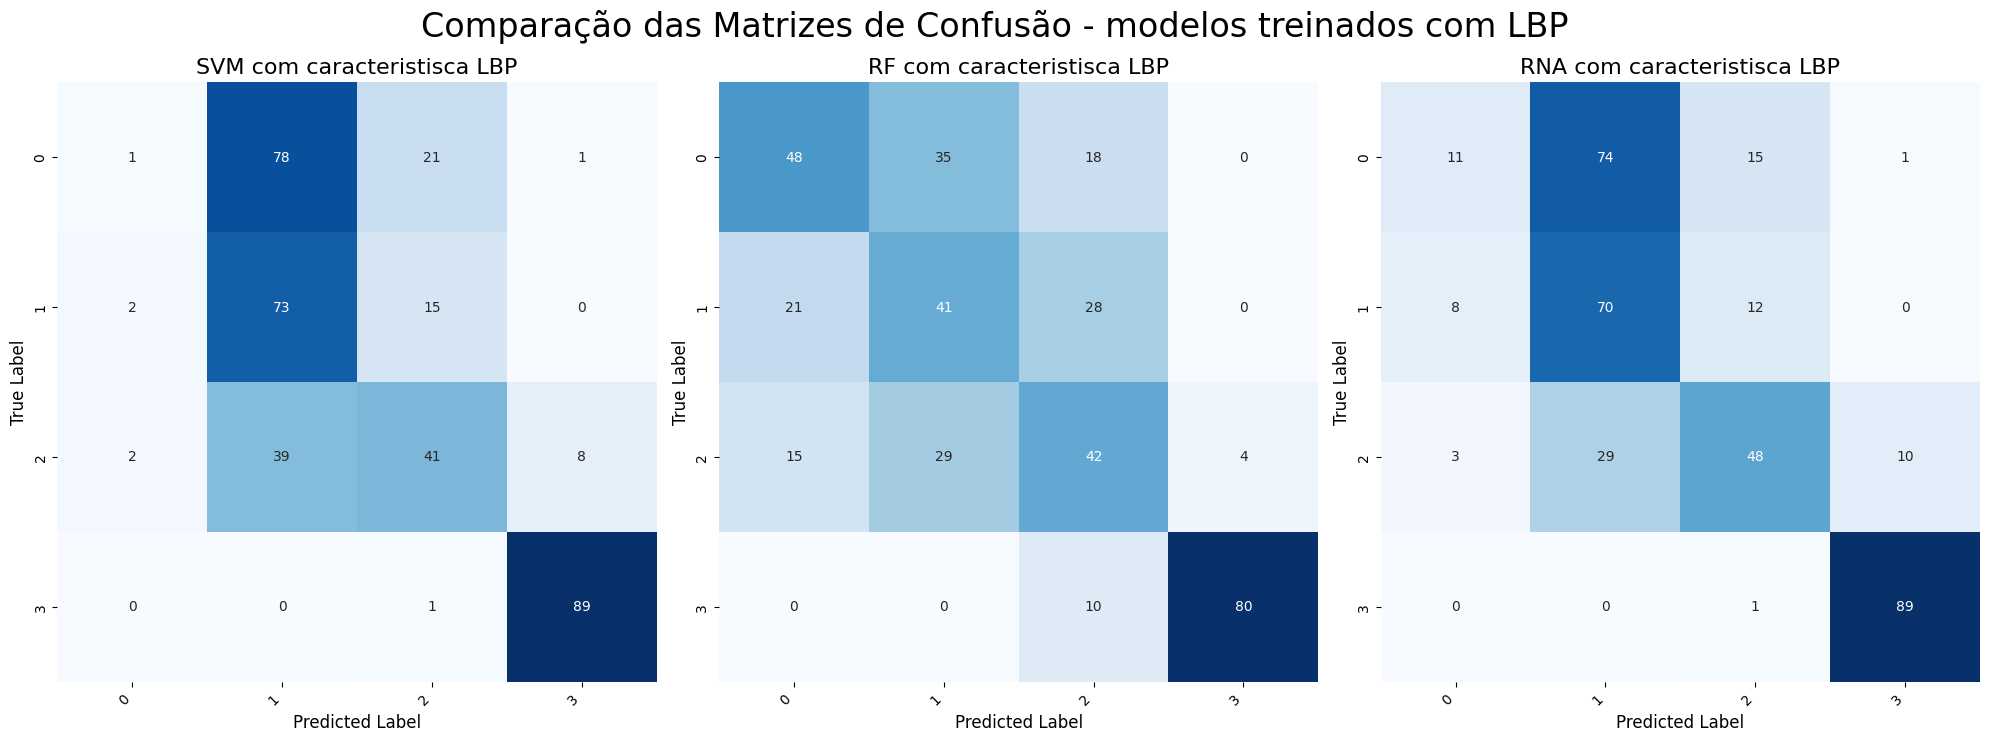

Métricas SVM LBP
              precision    recall  f1-score   support

           0      0.200     0.010     0.019       101
           1      0.384     0.811     0.521        90
           2      0.526     0.456     0.488        90
           3      0.908     0.989     0.947        90

    accuracy                          0.550       371
   macro avg      0.505     0.566     0.494       371
weighted avg      0.495     0.550     0.480       371

Métricas Randon Forest LBP
              precision    recall  f1-score   support

           0      0.571     0.475     0.519       101
           1      0.390     0.456     0.421        90
           2      0.429     0.467     0.447        90
           3      0.952     0.889     0.920        90

    accuracy                          0.569       371
   macro avg      0.586     0.572     0.576       371
weighted avg      0.585     0.569     0.575       371

Métricas Randon RNA LBP
              precision    recall  f1-score   support

       

In [235]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(y_test, y_pred_svm_lbp, classes, ax1, title="SVM com caracteristisca LBP")
plot_heatmap(y_test, y_pred_rf_lbp, classes, ax2, title="RF com caracteristisca LBP")
plot_heatmap(y_test, y_pred_rna_lbp, classes, ax3, title="RNA com caracteristisca LBP")

fig.suptitle("Comparação das Matrizes de Confusão - modelos treinados com LBP", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.2)
plt.show()

print("Métricas SVM LBP")
print(classification_report(y_test, y_pred_svm_lbp, digits=3))
print("Métricas Randon Forest LBP")
print(classification_report(y_test, y_pred_rf_lbp, digits=3))
print("Métricas Randon RNA LBP")
print(classification_report(y_test, y_pred_rna_lbp, digits=3))

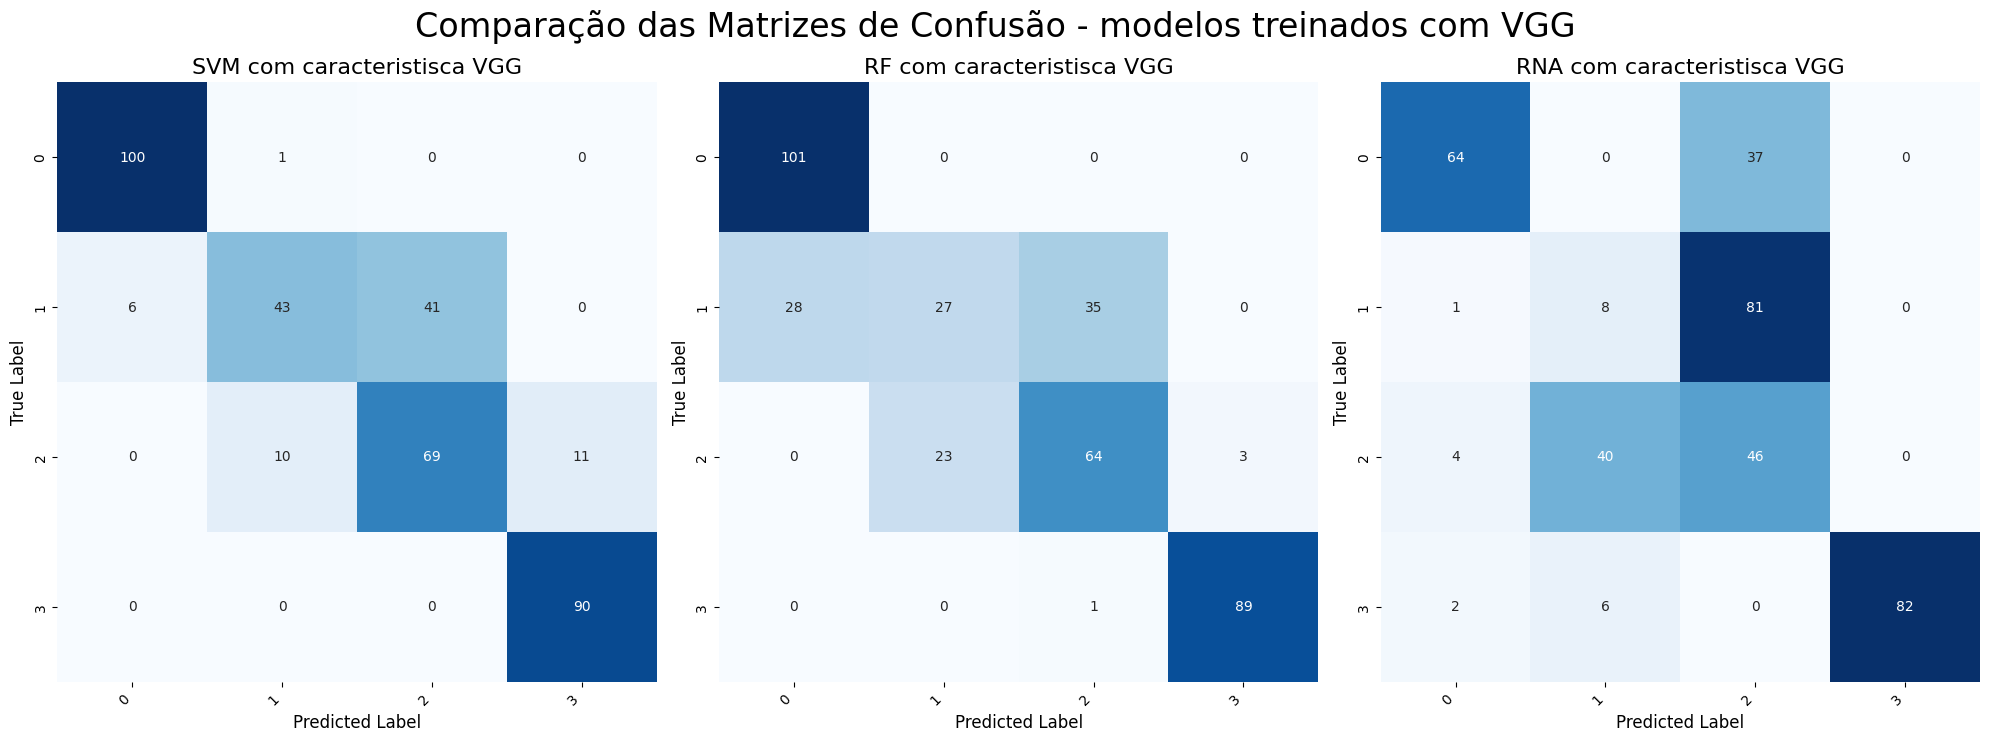

Métricas SVM VGG
              precision    recall  f1-score   support

           0      0.943     0.990     0.966       101
           1      0.796     0.478     0.597        90
           2      0.627     0.767     0.690        90
           3      0.891     1.000     0.942        90

    accuracy                          0.814       371
   macro avg      0.815     0.809     0.799       371
weighted avg      0.818     0.814     0.804       371

Métricas Randon Forest VGG
              precision    recall  f1-score   support

           0      0.783     1.000     0.878       101
           1      0.540     0.300     0.386        90
           2      0.640     0.711     0.674        90
           3      0.967     0.989     0.978        90

    accuracy                          0.757       371
   macro avg      0.733     0.750     0.729       371
weighted avg      0.734     0.757     0.733       371

Métricas Randon RNA VGG
              precision    recall  f1-score   support

       

In [237]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plot_heatmap(y_vgg_test, y_pred_svm_vgg, classes, ax1, title="SVM com caracteristisca VGG")
plot_heatmap(y_vgg_test, y_pred_rf_vgg, classes, ax2, title="RF com caracteristisca VGG")
plot_heatmap(y_vgg_test, y_pred_rna_vgg, classes, ax3, title="RNA com caracteristisca VGG")

fig.suptitle("Comparação das Matrizes de Confusão - modelos treinados com VGG", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.2)
plt.show()

print("Métricas SVM VGG")
print(classification_report(y_test, y_pred_svm_vgg, digits=3))
print("Métricas Randon Forest VGG")
print(classification_report(y_test, y_pred_rf_vgg, digits=3))
print("Métricas Randon RNA VGG")
print(classification_report(y_test, y_pred_rna_vgg, digits=3))

### 8. Indique qual modelo dá o melhor o resultado e a métrica utilizada

O melhor modelo é o **SVM** usando **features VGG**, pois apresenta a maior **F1 ponderada (0.804)** e também a maior **acurácia (0.814)**entre todos os modelos testados.

# 2. Redes Neurais

Utilize as duas bases do exercício anterior para treinar as Redes Neurais Convolucionais VGG16 e a Resnet50. Utilize os pesos pré-treinados (Transfer Learning), refaça as camadas Fully Connected para o problema de 4 classes. Treine só as novas camadas. Compare os treinos de 10 épocas com e sem Data Augmentation. Tanto a VGG16 quanto a Resnet50 têm como camada de entrada uma imagem 224x224x3, ou seja, uma imagem de 224x224 pixels coloridos (3 canais de cores). Portanto, será necessário fazer uma transformação de 250x250x3 para 224x224x3. Ao fazer o Data Augmentation cuidado para não alterar demais as cores das imagens e atrapalhar na classificação.

Tarefas:
1. Utilize a base de dados de Treino já separadas em treino e validação do exercício anterior.
2. Treine modelos VGG16 e Resnet50 adaptadas com e sem Data Augmentation
3. Aplique os modelos treinados nas imagens da base de Teste
4. Calcule as métricas de Sensibilidade, Especificidade e F1-Score com base em suas matrizes de confusão.
5. Indique qual modelo dá o melhor o resultado e a métrica utilizada